# MLflow Übungsaufgaben
> Übung zum Experimenttracking mit MLflow

## Übung 1 - Logging von Metriken und Parametern mit MLflow
> Ziel: In dieser Übung werden wir die Verwendung von MLflow zur Protokollierung von Metriken und Parametern in einem Machine Learning Workflow üben.

Codekommentare, die mit einem Ausrufungszeichen beginnen `#!` stellen ein TODO dar. Der Tracking-Server ist über die URL `http://localhost:5001` erreichbar.
**MLflow ist bereits als Package installiert.** 

### Importiere die notwendigen Bibliotheken

In [1]:
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
/opt/pysetup/.venv/lib/python3.11/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_server_url" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/pysetup/.venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)


### Lade einen Beispieldatensatz
In diesem Fall verwenden wir den Iris-Datensatz:

In [2]:
from sklearn.datasets import load_iris
data = load_iris()
X, y = data.data, data.target


### Teile den Datensatz in Trainings- und Testdaten auf

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Trainiere einen RandomForest-Klassifikator und logge von Hyperparamtern
Anzahl der Bäume und die Genauigkeit des Modells

In [4]:
#! Setze die verwendete Tracking-URI auf `http://mlflow:5001`
mlflow.set_tracking_uri("http://mlflow:5001")

In [5]:
#! Erstelle ein Experiment mit dem Namen `MLflow Regression Demo`. Speichere die experiment_id in der Variable `exp_id`.
try:
    exp_id = mlflow.create_experiment(name="MLflow Regression Demo")
except mlflow.exceptions.RestException:
   exp_id =  mlflow.get_experiment_by_name(name="MLflow Regression Demo").experiment_id

In [6]:
# Starte ein MLflow-Experiment
with mlflow.start_run(experiment_id=exp_id):

    # Logge die Anzahl der Bäume als Parameter
    num_trees = 200
    
    #! Logge den Hyperparameter `num_trees` als Parameter
    mlflow.log_param("num_trees", num_trees)
    dataset_input =mlflow.data.from_numpy(X, source="Input.csv")
    mlflow.log_input(dataset_input,context="input")

    # Trainiere das Modell
    clf = RandomForestClassifier(n_estimators=num_trees)
    clf.fit(X_train, y_train)

    # Berechne die Genauigkeit des Modells
    accuracy = clf.score(X_test, y_test)

    #! Logge die Genauigkeit (`accuracy`) als Metrik
    mlflow.log_metric("accuracy", accuracy)


/opt/pysetup/.venv/lib/python3.11/site-packages/mlflow/data/dataset_source_registry.py:143: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(


### Weitere Aufgaben
1. Setze die Anzahl an Bäumen `num_trees` in dem vorherigen Codeblock auf 200 und führe den Codeblock erneut aus. 
2. Rufe die URL `http://localhost:5001` in deinem Browser auf. Schaue dir beide Runs des Experimentes an.
3. Auf der Übersichtsseite der Runs des Experimentes `MLflow Regression Demo` können beide Runs angehakt werden. Tue dies und vergleiche die Experimente mit einem Klick auf `Compare`
4. Speichere vor dem Training die Datensätze `X` mit dem Context `input`

## Übung 2. - PyTorch Image Classifier mit MLflow
> Ziel: In dieser Übung erstellen wir einen Bildklassifikator mit PyTorch und verwenden MLflow, um das trainierte Modell zu überwachen.

### Laden der notwendigen Bibliotheken 

In [7]:
import mlflow
import mlflow.pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Laden des Fashion MNIST-Datensatz und erforderliche Transformationen durchführen

In [8]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data/FASHIONMNIST',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data/FASHIONMNIST',
    download=True,
    train=False,
    transform=transform)

batch_size = 4

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


100%|██████████| 26421880/26421880 [00:04<00:00, 5847009.04it/s] 


Extracting ./data/FASHIONMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FASHIONMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 1202382.36it/s]


Extracting ./data/FASHIONMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FASHIONMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 20228728.35it/s]


Extracting ./data/FASHIONMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FASHIONMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2148271.51it/s]


Extracting ./data/FASHIONMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FASHIONMNIST/FashionMNIST/raw



### Definieren eines einfachen CNN-Modells für die Bildklassifikation

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Trainiere das Modells

In [10]:
#! Erstelle ein Experiment mit dem Namen `MLflow Image Classifier Demo`. Speichere die experiment_id in der Variable `exp_id`.
try:
    mlflow.set_tracking_uri("http://mlflow:5001")
    exp_id = mlflow.create_experiment(name="MLflow Image Classifier Demo")
except mlflow.exceptions.RestException:
   exp_id =  mlflow.get_experiment_by_name(name="MLflow Image Classifier Demo").experiment_id

100%|██████████| 2/2 [03:00<00:00, 90.41s/it]
/opt/pysetup/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/opt/pysetup/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


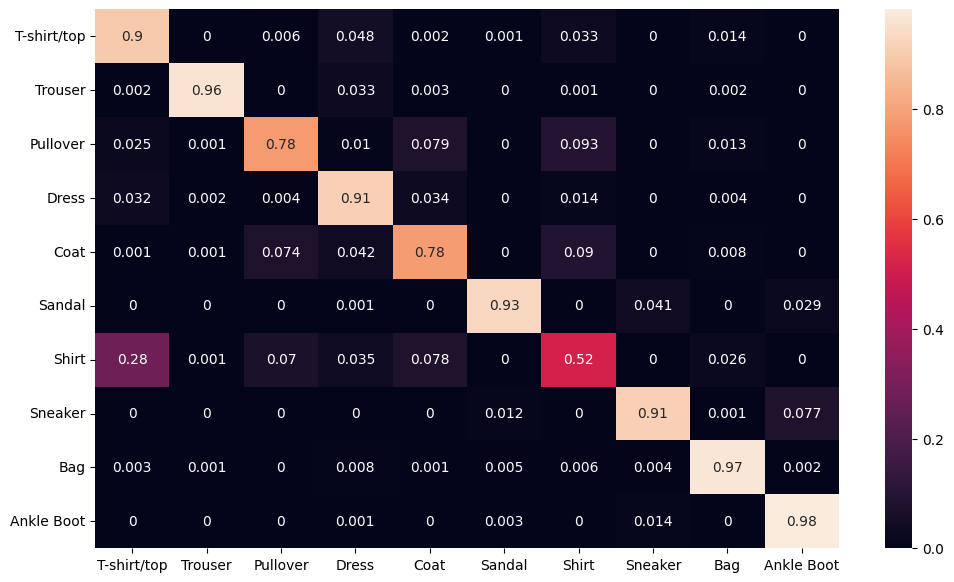

In [13]:

with mlflow.start_run(experiment_id=exp_id):
    learning_rate = 0.001
    epochs = 2

    
    #! Logge die Variable `batch_size`, `learning_rate` und `epochs` als Parameter
    mlflow.log_params({
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    net = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in tqdm(range(epochs)):  
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        #! Logge den Loss pro Epoche
        loss = running_loss / len(trainloader)
        mlflow.log_metric("loss", loss)
    
    # Speichere das trainierte Modell als Datei
    model_path = "model.pth"
    torch.save(net.state_dict(), model_path)
    
    #! Logge das gespeicherte Modell als Artefakt 
    mlflow.log_artifact(model_path)
    
    mlflow.pytorch.log_model(net, "model")

    create_confusion_matrix("confusion_matrix.png",net,testloader)
    mlflow.log_artifact("confusion_matrix.png","Confusion Matrix")

### Weitere Aufgaben
1. Logge das trainierte Modell über `mlflow.pytorch.log_model`
2. Füge in den oberen Codeblock den Aufruf der nachfolgenden Funktion `create_confusion_matrix` ein. Zuvor muss die Zelle mit der Funktion ausgeführt werden. Die gespeicherte Confusion Matrix soll als Artefakt geloggt werden.

In [12]:
def create_confusion_matrix(filename, net, testloader):
    y_pred = []
    y_true = []
    
    for inputs, labels in testloader:
        output = net(inputs)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

    classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(filename)

#### Confusion Matrix erstellen